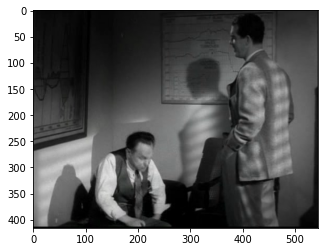

In [1]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

impath = glob.glob("HollywoodHeads/JPEGImages/*.jpeg")

path = impath[0]
img = cv2.imread(path)
plt.imshow(img)
plt.show()

xml_path = os.path.join("HollywoodHeads/Annotations",os.path.basename(path)[:-5] + '.xml')

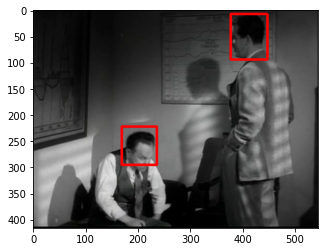

In [2]:

tree = ET.parse(xml_path)
root = tree.getroot()

objects = root.findall("object")
for obj in objects:
    bndbox = obj.find("bndbox")

    x1 = int(bndbox.find("xmin").text)
    y1 = int(bndbox.find("ymin").text)
    x2 = int(bndbox.find("xmax").text)
    y2 = int(bndbox.find("ymax").text)

    result = cv2.rectangle(img, (x1,y1),(x2,y2),(255,0,0), 3)
plt.imshow(result)
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from PIL import Image

In [4]:
def get_model(num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor =FastRCNNPredictor(in_features, num_classes)
    
    return model

In [5]:
class HeadDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.impath = glob.glob("HollywoodHeads/JPEGImages/*.jpeg")
        self.transform = transform
        
    def __getitem__(self, idx):
        path = self.impath[idx]
        xml_path = os.path.join("HollywoodHeads/Annotations",os.path.basename(path)[:-5] + '.xml')
        
        img = cv2.imread(path)
        
        tree = ET.parse(xml_path)
        root = tree.getroot()

        objects = root.findall("object")
        boxes = []
        try:
            for obj in objects:
                bndbox = obj.find("bndbox")
                x1 = int(float(bndbox.find("xmin").text))
                y1 = int(float(bndbox.find("ymin").text))
                x2 = int(float(bndbox.find("xmax").text))
                y2 = int(float(bndbox.find("ymax").text))
                boxes.append([x1,y1,x2,y2])
        except:
            print(path)
            boxes = []
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # print(boxes)
        num_objs = (len(objects))
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.ones((num_objs,), dtype=torch.int64)
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)
        
        if self.transform:
            img= self.transform(img)
        # print(target)
        return img, target
    
    def __len__(self):
        return len(self.impath)

In [6]:
from torchvision.transforms import ToTensor
transform = torchvision.transforms.Compose([ToTensor()])

dataset = HeadDataset(transform=transform)

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
indices = torch.randperm(len(dataset)).tolist()
t = int(len(dataset) * 0.8)
batch_size = 2

from torch.utils.data import Dataset, Subset, DataLoader
train_data, test_data = Subset(dataset, indices[:100]), Subset(dataset, indices[100:120])
data_loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
data_loader_test = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [9]:
if torch.cuda.is_available():
    device = 'cuda:1'
else:
    device = 'cpu'
    
num_classes = 2
labels = ['background', 'head']

model = get_model(num_classes=num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 20
iter_num = 0
batch_num = int(len(data_loader_train)/batch_size)
for epoch in range(num_epochs):
    model.train()
    avg_loss = 0
    for i, data in enumerate(data_loader_train):
        iter_num+=1
        
        images, targets = data
        
        images_ = [image.to(device) for image in images]
        targets_ = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images_, targets_)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        avg_loss += losses / batch_num
    
    print(f"epoch:{epoch} iter:{iter_num} loss:{avg_loss}")
    torch.save(model.state_dict(), f"frcnn_head_epoch{epoch}.pth")

/home/ubuntu/anaconda3/envs/pytorch171/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:0 iter:50 loss:0.7500874400138855
epoch:1 iter:100 loss:0.47460952401161194
epoch:2 iter:150 loss:0.37851032614707947
epoch:3 iter:200 loss:0.3295447528362274
epoch:4 iter:250 loss:0.27887463569641113
epoch:5 iter:300 loss:0.23312979936599731
epoch:6 iter:350 loss:0.21173366904258728
epoch:7 iter:400 loss:0.18455758690834045
epoch:8 iter:450 loss:0.17707668244838715
epoch:9 iter:500 loss:0.16627247631549835
epoch:10 iter:550 loss:0.14291977882385254
epoch:11 iter:600 loss:0.12522940337657928
epoch:12 iter:650 loss:0.11533194035291672
epoch:13 iter:700 loss:0.11216498166322708
epoch:14 iter:750 loss:0.10455571860074997
epoch:15 iter:800 loss:0.10058582574129105
epoch:16 iter:850 loss:0.0956280305981636
epoch:17 iter:900 loss:0.09291376173496246
epoch:18 iter:950 loss:0.0887424424290657
epoch:19 iter:1000 loss:0.0872485339641571


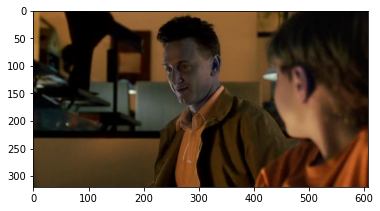

236 23 348 171
431 1 607 263


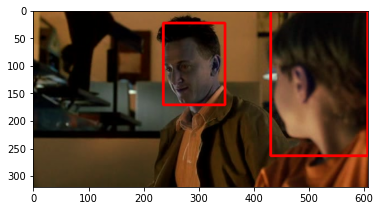

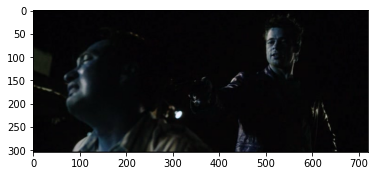

495 25 578 127
74 57 236 256


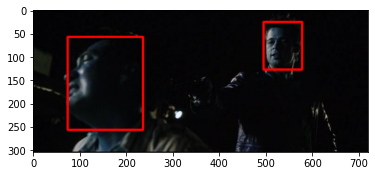

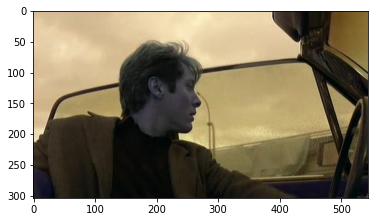

144 59 278 203


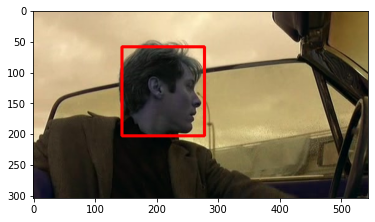

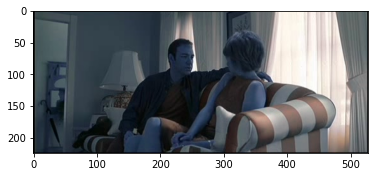

212 44 257 104
301 31 367 103


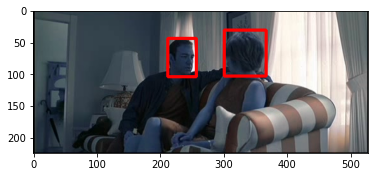

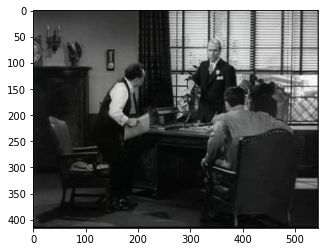

175 100 216 149
366 144 407 192
332 53 362 101


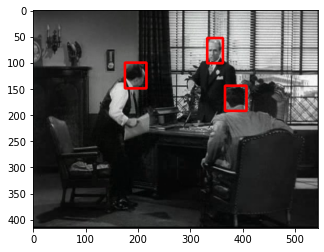

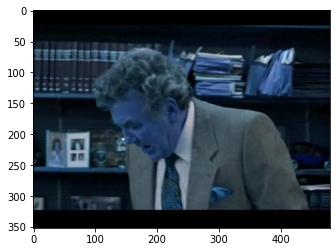

117 65 264 245


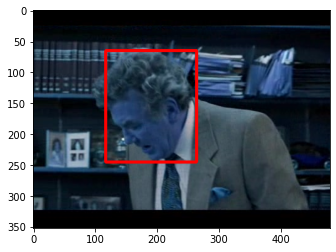

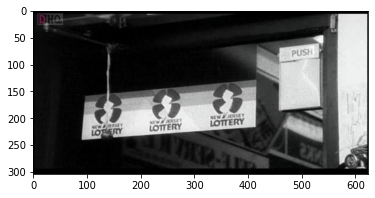

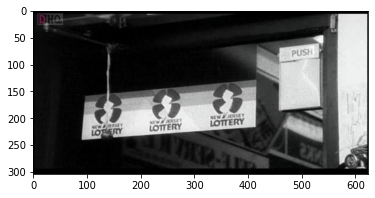

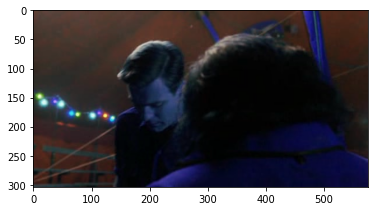

155 52 271 211
265 52 513 252


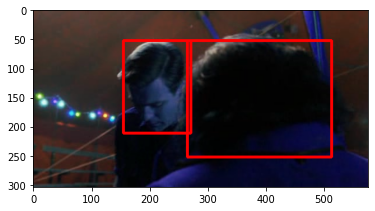

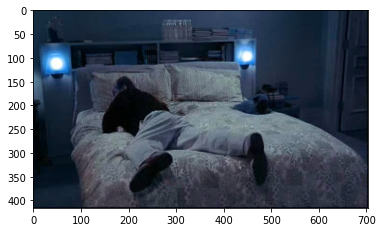

456 175 499 220


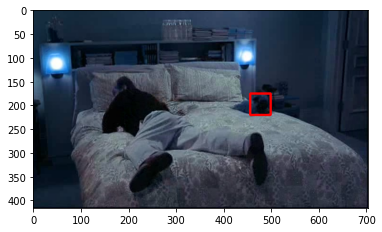

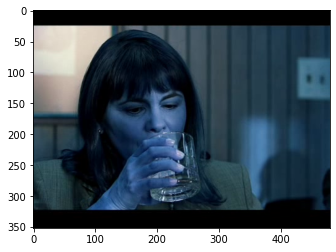

91 39 258 224


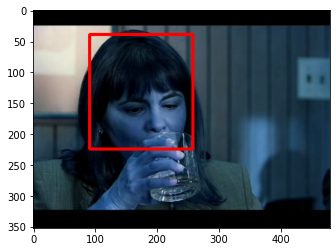

In [85]:
for i, data in enumerate(data_loader_test):
    img, target = data

    img_ = img[0].mul(255).permute(1,2,0).cpu().numpy().astype(np.uint8)
    # Image.fromarray(img_)
    plt.imshow(img_)
    plt.show()

    model.eval()
    with torch.no_grad():
        pred = model([img[0].to(device)])
    boxes = pred[0]['boxes'].cpu().numpy().astype(np.uint16)
    confs = pred[0]['scores'].cpu().numpy().astype(np.float16)
    draw_img = img_.copy()

    threshold = 0.5
    for idx, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        conf = confs[idx]
        if conf > threshold:
            cv2.rectangle(draw_img, (x1,y1),(x2,y2),(255,0,0), 3)
            print(x1,y1,x2,y2)
    plt.imshow(draw_img)
    plt.show()

In [1]:
img

NameError: name 'img' is not defined

175 100 216 149
366 144 407 192
332 53 362 101


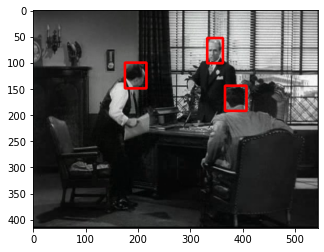

In [83]:
boxes = pred[0]['boxes'].cpu().numpy().astype(np.uint16)
confs = pred[0]['scores'].cpu().numpy().astype(np.float16)
draw_img = img_.copy()

threshold = 0.5
for idx, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    conf = confs[idx]
    if conf > threshold:
        cv2.rectangle(draw_img, (x1,y1),(x2,y2),(255,0,0), 3)
        print(x1,y1,x2,y2)
plt.imshow(draw_img)
plt.show()

In [82]:
pred

[{'boxes': tensor([[175.2908, 100.3081, 216.8318, 149.3262],
          [366.7215, 144.1651, 407.6606, 192.2070],
          [332.2311,  53.1859, 362.6404, 101.3128]], device='cuda:1'),
  'labels': tensor([1, 1, 1], device='cuda:1'),
  'scores': tensor([0.9957, 0.9946, 0.9746], device='cuda:1')}]

345 10 492 204


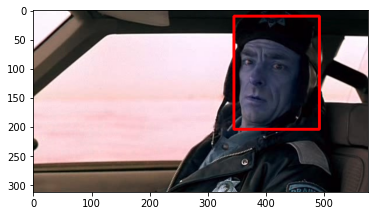

error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
